# Notebook 5 - Prédiction sur le Titanic

CSI4506 Intelligence Artificielle  
Automne 2020  
Preparé par Joel Muteba, Julian Templeton et Caroline Barrière

***INTRODUCTION***:

La tâche de classification supervisée abordée dans ce notebook est de déterminer si un passager a survécu ou non sur le Titanic. Il s'agit d'un problème d'introduction courant à l'apprentissage machine supervisé et constitue un défi sur un site populaire appelé Kaggle. Kaggle contient des compétitions auxquelles les utilisateurs peuvent participer. Ces compétitions fournissent généralement un ensemble de données avec lequel travailler et une description du problème à résoudre. Cela dit, tous les ensembles de données n'incluront pas la valeur à prédire pour l'ensemble de test. Ou bien, un concours peut uniquement fournir un ensemble d'entraînement et de validation, pas l'ensemble de test. Cela signifie que les utilisateurs ne sauront pas comment leurs modèles fonctionnent sur les données réelles invisibles jusqu'à ce que le ou les hôtes testent la soumission de l'utilisateur sur l'ensemble de test privé et publient les résultats.

Ce notebook enrichira vos connaissances du notebook précédent et présentera le concept de gestion du déséquilibre de classe grâce à l'utilisation d'une technique appelée suréchantillonnage. Vous verrez également comment un ensemble de données peut avoir des problèmes avec ses données et que tous les attributs ne doivent pas être utilisées pour entraîner et tester un modèle. Vous effectuerez également l'entraînement, les tests et l'évaluation de manière légèrement nouvelle puisque nous travaillerons avec un type différent d'ensemble de données.

Encore une fois, ce notebook utilise **scikit-learn** (http://scikit-learn.org/stable/), **Matplot**, **Numpy** et **Pandas**. Cependant, nous utiliserons également **imblearn** qui fournit des techniques robustes pour équilibrer le nombre d'instances de différentes classes. Pour installer ce package, utilisez la commande ***pip install imbalanced-learn***. Si cela pose des problèmes, vous pouvez également essayer *pip install imblearn*.

Dans ce notebook, nous utiliserons l'algorithme Naive Bayes et l'algorithme de régression logistique pour effectuer la classification de ce problème. Après avoir évalué les deux modèles, vous déterminerez celui qui a le mieux fonctionné et pourquoi. Enfin, vous recommencerez le processus pour déterminer si une technique de suréchantillonnage commune améliorera ou non les résultats obtenus.

***Devoir***:

Parcourez le notebook en exécutant chaque cellule, une à la fois.
Recherchez **(TO DO)** pour les tâches que vous devez effectuer. Ne modifiez pas le code en dehors des questions auxquelles vous êtes invité à répondre à moins que cela ne vous soit spécifiquement demandé. Une fois que vous avez terminé, signez le notebook (à la fin du notebook) et soumettez-le.

*Le notebook sera noté le 30.
Chaque **(TO DO)** a un certain nombre de points qui lui sont associés.*
***

**1. Exploration de l'ensemble de données**   

Tout d'abord, nous allons configurer les données avec lesquelles nous travaillerons. Ces données sont incluses avec le notebook et peuvent être trouvées auprès de Kaggle, qui contient également une description des données avec lesquelles nous travaillerons (https://www.kaggle.com/c/titanic/data). Il est fortement recommandé de jeter un coup d'œil rapide au dictionnaire de données dans la section Overview qui est disponible via le lien ci-dessus. Cela vous aidera à comprendre les données avec lesquelles nous travaillerons.

Comme évoqué dans l'introduction, ce concours Kaggle ne fournit que des données d'entraînement annotées, tandis que les données de test ne sont pas annotées. Les valeurs de sorties (prédites) de l'ensemble de données de test peuvent-être trouvées en ligne, mais nous nous concentrerons uniquement sur l'utilisation de l'ensemble de données d'entraînement pour créer et tester notre modèle. Cela vous fournira un type de processus d'expérimentation d'apprentissage machine différent.

Il existe de nombreux cas où une compétition ne donnera qu'un ensemble d'entraînement, nous essaierons donc de savoir si un passager a survécu ou non sur le Titanic à partir de ces données d'entraînement.

In [2]:
# Import the required packages for data analysis and machine learning
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Tout d'abord, nous allons charger l'ensemble de données d'entraînement (*train.csv*) dans un dataframe avec Pandas et explorer les dix premiers échantillons. Notez que cet ensemble de données contient une variété de colonnes (features) potentielles, contrairement aux critiques de films avec lesquelles nous avons travaillé dans le dernier notebook qui contenait des critiques de films que nous devions transformer. Cet ensemble de données contient à la fois des valeurs continues et discrètes.

In [3]:
# Read the dataset, show top ten rows
X = pd.read_csv("train.csv")
X.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


De ce qui précède, nous pouvons voir une variété de colonnes. Sur ces colonnes, la colonne ***Survived*** représente les valeurs de classe que nous souhaitons prédire. Un passager a survécu du Titanic si *Survived* vaut 1 et n'a pas survécu du Titanic si *Survived* est 0. Ce sont nos deux classes que nous prédirons (1 et 0). Les autres colonnes représentent des attributs potentiels qui peuvent être utilisées par les algorithmes d'apprentissage machine pour apprendre à prédire avec précision la classe cible.

Une remarque importante des données ci-dessus est que tous les échantillons ne contiennent pas de données pour chaque colonne. Par exemple, le passager 6 (Moran, M. James) ne contient pas de valeur pour son *âge* et ne contient pas la *cabine* dans laquelle il résidait. Étant donné que les algorithmes d'apprentissage machine apprennent à partir de données, un Data Scientist devra apprendre à remplir avec précision les données manquantes. Les méthodes robustes pour ce faire dépassent le cadre de ce notebook, mais nous remplirons plus tard la plupart des données manquantes par des moyens simples.

Une autre remarque est qu'il est important de déterminer si une classe est vue plus fréquemment qu'une autre classe dans les données. Une classe avec le plus d'instances est appelée la classe *majoritaire* et une classe avec le moins d'instances est appelée la classe *minoritaire*. Si une classe contient plus d'instances qu'une autre classe, l'algorithme peut se concentrer sur l'apprentissage de cette classe majoritaire plus que de la classe minoritaire. Dans des problèmes tels que le diagnostic du cancer, il s'agit d'un problème majeur (car beaucoup plus de personnes n'ont pas de cancer). Ainsi, un autre problème que nous explorerons dans ce notebook est le concept d'utilisation du suréchantillonnage pour équilibrer la distribution des classes. Ce concept sera expliqué en détail plus loin dans le notebook.  

Vous trouverez ci-dessous un graphique du nombre d'instances pour chaque classe. Dans ce scénario, sur base des données disponibles de l'ensemble d'entraînement, plus de personnes n'ont pas survécu sur le Titanic que celles qui ont survécu (comme on pourrait s'y attendre dans ce scénario). Puisque nous ne pouvons pas simplement collecter plus de données sur les passagers qui ont survécu au Titanic, nous devrons réfléchir à des moyens d'équilibrer la répartition des classes.

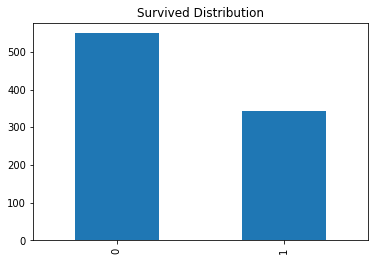

In [4]:
plt.figure() # Creates a new figure
X["Survived"].value_counts().plot(kind="bar", title="Survived Distribution")
plt.show()

Dans cet esprit, nous allons maintenant déplacer les valeurs de classe (de sortie) du dataframe X de pandas dans un tableau numpy appelé y. X est généralement utilisé pour désigner les attributs d'entrées et y est généralement utilisé pour représenter les valeurs de classe (ou sortie).

In [5]:
# This can ONLY BE DONE ONCE, as we pop the values into a new variable to be used as predicted class
y = X.pop("Survived").values

Puisque nous avons examiné la distribution des classes, nous allons maintenant examiner les autres attributs disponibles dans l'ensemble de données. Ci-dessous, nous imprimons une liste de tous les attributs disponibles et explorons les propriétés de la colonne *Embarked*.

In [6]:
# Show all attributes
print(list(X))
# Examples of data exploration
print(X.shape)
print(X['Embarked'].value_counts())

['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
(891, 11)
S    644
C    168
Q     77
Name: Embarked, dtype: int64


D'après l'avis ci-dessus, on peut voir que l'attribut *Embarked* contient 644 valeurs *S*, 168 *C* valeurs et 77 *Q* valeurs. Mais c'est en fait deux de moins que le total de 891 instances. Ainsi, il y a deux valeurs manquantes dans cet attribut. Ceci est indiqué via le code ci-dessous:

In [7]:
# Find the rows with a null Embarked value
X[X['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


**(TO DO) Q1 - 2 points**   
En vous basant sur l'exemple ci-dessus, explorez les attributs *Age* et *Cabin*. Imprimez les valeurs qu'ils contiennent et les lignes où il leur manque des valeurs. Notez que certaines valeurs peuvent ne pas être explicitement affichées lorsqu'elles sont appelées (représentées par ...), donc tant que les premières et les dernières lignes apparaissent, c'est bien.

In [8]:
# Find the rows with a null Embarked value
print(X['Age'].value_counts())
X[X['Age'].isnull()]

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
859,860,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [9]:
# TODO Q1: For the Cabin attribute
print(X['Cabin'].value_counts())
X[X['Cabin'].isnull()]

B96 B98        4
G6             4
C23 C25 C27    4
E101           3
C22 C26        3
              ..
C70            1
A20            1
B102           1
A32            1
B39            1
Name: Cabin, Length: 147, dtype: int64


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
884,885,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


**2. Nettoyage des données**    

Après avoir exploré l'ensemble de données, nous allons maintenant travailler sur le nettoyage de certaines des valeurs manquant dans les attributs que nous utiliserons pour les algorithmes d'apprentissage machine.

Plus précisément, nous remplirons les valeurs manquantes pour les attributs *Age* et *Embarked*. Bien qu'il soit également possible de le faire pour l'attribut *Cabin*, cet attribut nécessite des précautions supplémentaires lors du remplissage de ses valeurs manquantes. Ainsi, ce notebook n'explorera pas l'attribut *Cabin* malgré son importance (puisque la localisation du passager est un identifiant important pour savoir s'il a survécu ou non).

Pour déterminer comment remplir les valeurs manquantes, nous considérerons la valeur moyenne de l'attribut lui-même ou d'autres attributs pour remplir les valeurs manquantes. Cependant, des méthodes plus robustes peuvent être utilisées. Pour votre propre intérêt, l'article suivant fait un bon travail en discutant de certaines des méthodes disponibles: https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4. Notez que le terme *imputation* fait référence au processus de remplissage des valeurs manquantes.

Pour l'attribut *Age*, nous remplirons les valeurs manquantes avec une méthode triviale. Les valeurs manquantes seront remplies avec l'âge moyen des passagers qui contiennent une valeur d'âge non nulle. Bien que cela causera probablement des problèmes, comme faire apprendre à l'algorithme des modèles inexacts à partir des valeurs d'âge moyennes, il s'agit de l'une des nombreuses approches trival pour remplir les données manquantes.

In [10]:
# Update the dataframe by filling in all missing age values as the mean of existing age values.
X["Age"].fillna(X["Age"].mean(), inplace=True)

Pour l'attribut *Embarked*, nous ferons un peu plus d'investigation sur ce que devraient être les valeurs. Puisqu'il n'y a que deux valeurs manquantes et qu'il y a trois options disponibles pour ces valeurs, nous sélectionnerons manuellement la valeur à affecter aux lignes manquantes. Ci-dessous, nous voyons les moyennes de tous les attributs numériques de l'ensemble de données, pour chacune des trois valeurs *Embarked* possibles.

In [11]:
# Isolate the rows for each possible value of Embarked (S, C, Q)
# Get the mean values when equal to S
df_embarked_S = X.loc[X["Embarked"] == 'S']
print("When Embarked equals S:")
print(df_embarked_S.describe().loc[['mean']])
# Get the mean values when equal to C
df_embarked_C = X.loc[X["Embarked"] == 'C']
print("\nWhen Embarked equals C:")
print(df_embarked_C.describe().loc[['mean']])
# Get the mean values when equal to Q
df_embarked_Q = X.loc[X["Embarked"] == 'Q']
print("\nWhen Embarked equals Q:")
print(df_embarked_Q.describe().loc[['mean']])

When Embarked equals S:
      PassengerId    Pclass        Age     SibSp     Parch       Fare
mean    449.52795  2.350932  29.480855  0.571429  0.413043  27.079812

When Embarked equals C:
      PassengerId    Pclass        Age     SibSp     Parch       Fare
mean   445.357143  1.886905  30.562419  0.386905  0.363095  59.954144

When Embarked equals Q:
      PassengerId    Pclass        Age     SibSp     Parch      Fare
mean   417.896104  2.909091  29.113724  0.428571  0.168831  13.27603


Maintenant, jetons un dernier coup d'œil aux lignes avec des valeurs *Embarked* manquantes.

In [12]:
# Look at the rows with missing Embarked values again
X[X['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Étant donné que les deux lignes ci-dessus contiennent principalement des données similaires, il est prudent de dire qu'elles se verront attribuer les mêmes valeurs *Embarked*. En comparant les valeurs de ces lignes aux valeurs moyennes vues ci-dessus, on peut voir que lorsque *Embarked* est égal à C, les moyennes de tous les attributs (à l'exception de PassengerId, qui n'a pas de sens) sont les plus proches des valeurs d'attribut trouvées dans les deux ces lignes. Par conséquent, nous attribuerons la valeur C à l'attribut * Embarqué * des deux lignes ci-dessus.

In [13]:
# Replace all NaN values for the Embarked column with the value 'C'
X["Embarked"].fillna('C', inplace=True)

**(TO DO) Q2 - 2 points**   
Imaginons que nous voulions remplir les valeurs manquantes pour les attributs *Age* et *Embarked* via une autre méthode. Proposez une méthode unique pour remplir les valeurs manquantes (peuvent être triviales ou complexes) pour l'attribut *Age* et une autre méthode unique pour remplir les valeurs manquantes pour l'attribut *Embarked*. Répondez dans la cellule ci-dessous.

TODO: Q2    

Pour l'attribut *Age*, nous remplirons les valeurs manquantes avec une méthode triviale. Les valeurs manquantes seront remplies avec l'âge median des passagers qui contiennent une valeur d'âge non nulle.

Pour l'attribut *Embarked*, nous remplirons les valeurs manquantes avec une méthode un peu plus poussee. Les valeurs manquantes seront remplies avec la moyenne de l attributs numériques *fare* de l'ensemble de données, pour chacune des trois valeurs Embarked possibles.

Avant de sélectionner les attributs à utiliser, nous convertirons les données catégorielles dans les colonnes *Sex* et *Embarked* en numériques. Cela se fera via un le one-hot-encoding, où chaque valeur catégorielle possible pour un attribut est conçue pour être son propre attribut. Ensuite, un seul de ces trois attributs contiendra la valeur 1 pour une ligne, où les autres contiennent 0. Dans le prochain notebook, nous explorerons le OneHotEncoder fourni par sklearn, mais nous traiterons cela manuellement avec les pandas pour ce notebook (via la fonction *get_dummies*).

In [14]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
# Convert the categorical values stored within the Sex column to be numerical via One-Hot-Encoding
X = pd.concat([X, pd.get_dummies(X['Sex'], prefix='Sex')], axis=1)
# Drop the original column
X.drop(['Sex'], axis=1, inplace=True)
# Convert the categorical values stored within the Embarked column to be numerical via One-Hot-Encoding
X = pd.concat([X, pd.get_dummies(X['Embarked'], prefix='Embarked')], axis=1)
# Drop the original column
X.drop(['Embarked'], axis=1, inplace=True)

Jetons un dernier coup d'œil aux 5 premières entrées de notre ensemble de données. Regardez en quoi les colonnes diffèrent de la sortie ci-dessus.

In [16]:
X.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1
4,5,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1


**3. Sélection des attributs et définition des ensembles de test et validation**    

Maintenant que les données sont prêtes à être utilisées, nous allons maintenant sélectionner les attributs avec lesquels nous allons travailler et définir les ensembles d'entraînement et de validation à partir des données disponibles. Pour notre sélection d'attributs, nous sélectionnerons simplement tous les attributs non nuls à l'exception de *PassengerId*, *Ticket* et *Name*.

PassengerId est un numéro unique pour chaque passager et ne peut donc pas fournir de modèles utiles concernant les valeurs de classe cible. Il est également peu probable que les noms permettent de savoir si un passager a survécu ou non.

Bien que nous puissions modifier l'attribut *Nom* pour qu'il devienne une valeur numérique basée sur le nombre de lettres dans le nom (peut-être que les noms avec plus de lettres de l'alphabet avaient un taux de survie plus élevé), nous ne le ferons pas car c'est une ligne de pensée illogique pour ce problème.

Ticket est une valeur qui ne semble pas non plus fournir d'informations utiles. Par conséquent, nous ne l'utiliserons pas.

Examinons les attributs restants avec des valeurs nulles après notre nettoyage des données pour voir ce qui ne sera pas sélectionné en tant qu'attribut.

In [17]:
# Look at what is null
X.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Sex_female       0
Sex_male         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
dtype: int64

Comme nous pouvons le voir, tous les attributs à l'exception de *Cabin* ne contiennent aucune valeur manquante. Bien que *Cabin* soit important, nous l'exclurons car nous ne l'avons pas correctement nettoyé et il manque une valeur à la majorité des données. Bien que nous puissions ignorer toutes les lignes qui ne contiennent pas de valeur *Cabin* ou que nous puissions attribuer une valeur «inconnue» aux valeurs manquantes, il y a trop de valeurs manquantes pour que cela soit raisonnable.

Pour le reste des attributs, bien que nous puissions bénéficier de la combinaison de certains attributs similaires (tels que Parch et SibSp), nous les utiliserons tels quels car ce sont des attributs qui peuvent donner un aperçu du fait qu'un passager a survécu ou non.
       
Par exemple, peut-être plus de femmes ont survécu que d'hommes ou peut-être de jeunes passagers ont survécu plus fréquemment que de passagers plus âgés.

In [18]:
# Define the list of attributes to use as features for the algorithms.
featureSet = ['Pclass', 'Sex_female', 'Sex_male', 'Age', 'SibSp', 
              'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [19]:
# Set the dataframe to only contain the desired variables
X = X[featureSet].copy()

Une fois les attributs sélectionnées, nous allons maintenant diviser les données en un ensemble d'entraînemet et de validation à partir des données disponibles. Puisque nous n'avons pas les valeurs de classe de l'ensemble de test explicite (mais que nous avons un ensemble de test), l'ensemble de test produit par scikit-learn sera utilisé pour valider si l'apprentissage semble réussi. Ceci est considéré comme l'ensemble de validation malgré le nom de l'appel de fonction de sklearn.

In [20]:
# split the large dataset into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=2)
# Look at the shape of the outputs
print(X_train.shape)
print(y_val.shape)

(712, 10)
(179,)


In [21]:
# Look at the training set
X_train.head()

,Pclass,Sex_female,Sex_male,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
30,1,0,1,40.0,0,0,27.7208,1,0,0
10,3,1,0,4.0,1,1,16.7000,0,0,1
873,3,0,1,47.0,0,0,9.0000,0,0,1
182,3,0,1,9.0,4,2,31.3875,0,0,1
876,3,0,1,20.0,0,0,9.8458,0,0,1


In [22]:
# Look at the validation set
X_val.head()

,Pclass,Sex_female,Sex_male,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
707,1,0,1,42.0,0,0,26.2875,0,0,1
37,3,0,1,21.0,0,0,8.0500,0,0,1
615,2,1,0,24.0,1,2,65.0000,0,0,1
169,3,0,1,28.0,0,0,56.4958,0,0,1
68,3,1,0,17.0,4,2,7.9250,0,0,1


**4. Techniques d'évaluation**    

Plus tard, nous utiliserons davantage de techniques d'évaluation pour mieux évaluer les performances des modèles. Pour l'instant, nous allons définir des fonctions pour calculer les métriques *Précision*, *Rappel* et *Accuracy*. Tous ces éléments ont été abordés dans le notebook précédent.

L'accuracy représente le pourcentage de classifications correctement effectuées par le modèle.

In [23]:
def precision(actualTags, predictions, classOfInterest):
    '''
    Calculates the precision for a specific class, given the ground truth and predicted values.
    '''
    totalFound = 0
    for i in range(len(actualTags)):
        if (actualTags[i] == classOfInterest and actualTags[i] == predictions[i]):
            totalFound += 1
    return totalFound / np.count_nonzero(predictions == classOfInterest)

In [24]:
def recall(actualTags, predictions, classOfInterest):
    '''
    Calculates the recall for a specific class, given the ground truth and predicted values.
    '''
    totalFound = 0
    for i in range(len(actualTags)):
        if (actualTags[i] == classOfInterest and actualTags[i] == predictions[i]):
            totalFound += 1
    return totalFound / np.count_nonzero(actualTags == classOfInterest)

In [25]:
def accuracy(actualTags, predictions):
    '''
    Calculates the average number of correct predictions.
        - actualTags: The ground truth
        - predictions: What the model predicts
    '''
    totalFound = 0
    for i in range(len(actualTags)):
        if (actualTags[i] == predictions[i]):
            totalFound += 1
    return totalFound / len(predictions)

In [26]:
# Example of calculating accuracy
accuracy([0, 1, 1, 1, 0], [1, 1, 1, 0, 1])

0.4

**5. Naive Bayes**    

Avec les données prétraitées et plusieurs fonctions d'évaluation définies, nous sommes maintenant prêts à utiliser certains algorithmes d'apprentissage machine pour effectuer les prédictions de savoir si un passager a survécu ou non sur le Titanic.

La première approche que nous utiliserons est l'algorithme Naive Bayes fourni par scikit-learn. Ce sera un processus très similaire à ce que vous avez fait dans le notebook 4. Vous entraînerez le modèle en appelant la fonction *fit* et récupérerez les prédictions du modèle en appelant la fonction *predict*. Contrairement au dernier notebook, nous avons déjà toutes nos données prétraitées en tant qu'attributs numériques dans un dataframe pandas, avec les étiquettes de classe sous forme de tableaux numpy (y_train et y_val). Ainsi, nous n'aurons pas besoin d'effectuer des transformations, telles que celles qui ont été effectuées dans le notebook 3.

La première tâche consiste à entraîner le modèle avec la fonction .fit().

In [27]:
# Train the model with the training set by calling the .fit() function
# X_train contains the features used to train the model
# y_train contains the class labels for the samples from X_train
clf_nb = MultinomialNB().fit(X_train, y_train)

Nous pouvons ensuite voir comment l'algorithme fonctionne lors de la prédiction des échantillons dans l'ensemble d'apprentissage via le code suivant.

In [28]:
print("Comparing the first ten actual values to the predicted values:")
# Print the first ten class labels for the training set
print(y_train[0:10])
# Predict whether the passengers did or did not survive the Titanic on the training set
nb_train_predictions = clf_nb.predict(X_train)
# Print the first ten predictions
print(nb_train_predictions[0:10])
print("Calculating the total accuracy for the training set:")
print(accuracy(y_train, nb_train_predictions))

Comparing the first ten actual values to the predicted values:
[0 1 0 0 0 0 0 1 1 0]
[0 1 0 1 0 0 0 0 0 0]
Calculating the total accuracy for the training set:
0.6980337078651685


D'après ce qui précède, nous pouvons voir qu'après avoir été entraîné, le modèle peut prédire correctement un peu moins de 70% de tous les échantillons de l'ensemble d'apprentissage. Mais comment fonctionne-t-il sur l'ensemble de validation?

**(TO DO) Q3 - 3 points**   
En suivant l'exemple fourni ci-dessus, obtenez les prédictions du modèle Naive Bayes sur l'ensemble de validation (X_val, y_val) et imprimez la précision, le rappel et l'accuracy de l'ensemble de validation (pour les deux classes, 1 et 0).

In [29]:
# TODO
clf_nb = MultinomialNB().fit(X_val, y_val)
# Get the predictions for the validation set
nb_val_predictions = clf_nb.predict(X_val)
# Retrieve and print the precision values for class 1 and class 0
print("Precision when class = 0: " + str(precision(y_val, nb_val_predictions, 0)))
print("Precision when class = 1: " + str(precision(y_val, nb_val_predictions, 1)))
# Retrieve and print the recall values for class 1 and class 0
print("Recall when class = 0: " + str(recall(y_val, nb_val_predictions, 0)))
print("Recall when class = 1: " + str(recall(y_val, nb_val_predictions, 1)))
# Retrieve and print the accuracy for the model
print("Accuracy: " + str(accuracy(y_val, nb_val_predictions)))

Precision when class = 0: 0.6666666666666666
Precision when class = 1: 0.6785714285714286
Recall when class = 0: 0.82
Recall when class = 1: 0.4810126582278481
Accuracy: 0.6703910614525139


**6. Régression Logistique**    

Avec les prédictions et les données obtenues pour l'algorithme d'apprentissage machine Naive Bayes, nous allons essayer d'utiliser un autre algorithme d'apprentissage machine qui peut ou non fonctionner mieux que l'approche Naive Bayes. Plus précisément, nous utiliserons l'algorithme d'apprentissage machine de régression logistique pour prédire qui a survécu et n'a pas survécu sur le Titanic.

Puisque l'algorithme de régression logistique que nous allons utiliser provient également de scikit-learn, le processus général sera presque identique à ce que nous avons fait pour le classificateur Naive Bayes. La principale différence est que nous allons maintenant utiliser un algorithme différent contenant certaines options que nous devrons définir. Tous les détails des façons possibles d'ajuster le modèle de régression logistique sont disponibles [ici] (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Nous allons d'abord initialiser et entraîner le modèle avec les données d'apprentissage.

In [29]:
# Train the model with the training set by calling the .fit() function
# X_train contains the features used to train the model
# y_train contains the class labels for the samples from X_train
clf_lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1).fit(X_train, y_train)

Ensuite, nous verrons comment le modèle fonctionne sur les données d'entraînement pour avoir une idée de la façon dont l'entraînement s'est déroulé. Puisque nous nous sommes entraînés sur ces données, nous espérons obtenir des résultats solides.

In [30]:
print("Comparing the first ten actual values to the predicted values:")
# Print the first ten class labels for the training set
print(y_train[0:10])
# Predict whether the passengers did or did not survive the Titanic on the training set
lr_train_predictions = clf_lr.predict(X_train)
# Print the first ten predictions
print(lr_train_predictions[0:10])
print("Calculating the total accuracy for the training set:")
print(accuracy(y_train, lr_train_predictions))

Comparing the first ten actual values to the predicted values:
[0 1 0 0 0 0 0 1 1 0]
[0 1 0 0 0 0 0 1 0 0]
Calculating the total accuracy for the training set:
0.8103932584269663


**(TO DO) Q4 - 3 points**   
En suivant l'exemple fourni ci-dessus, obtenez les prédictions du modèle de régression logistique sur l'ensemble de validation (X_val, y_val) et imprimez la précision, le rappel et l'accuracy de l'ensemble de validation.

In [31]:
# TODO
clf_lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1).fit(X_val, y_val)
# Get the predictions for the validation set
lr_val_predictions = clf_lr.predict(X_val)
# Retrieve and print the precision values for class 1 and class 0
print("Precision when class = 0: " + str(precision(y_val, lr_val_predictions, 0)))
print("Precision when class = 1: " + str(precision(y_val, lr_val_predictions, 1)))
# Retrieve and print the recall values for class 1 and class 0
print("Recall when class = 0: " + str(recall(y_val, lr_val_predictions, 0)))
print("Recall when class = 1: " + str(recall(y_val, lr_val_predictions, 1)))
# Retrieve and print the accuracy for the model
print("Accuracy: " + str(accuracy(y_val, lr_val_predictions)))

Precision when class = 0: 0.7788461538461539
Precision when class = 1: 0.7466666666666667
Recall when class = 0: 0.81
Recall when class = 1: 0.7088607594936709
Accuracy: 0.7653631284916201


**7. Plus de techniques d'évaluation**    

Maintenant que vous avez entraîné et testé les modèles ci-dessus, vous allez définir deux méthodes d'évaluation supplémentaires. La première sera la micro-moyenne sur les précisions et la seconde sera la macro-moyenne sur les précisions. Les définitions de ceux-ci se trouvent dans votre matériel de cours.

Bien que nous puissions également définir la micro-moyenne et la macro-moyenne pour les rappels, nous ne le ferons pas pour ce notebook afin d'éviter d'avoir trop de mesures d'évaluation à prendre en compte. En réalité, chaque ensemble de données aura des critères d'évaluation qui sont de plus en moins importants pour évaluer le problème.

**(TO DO) Q5 - 2 points**   

Dans la cellule ci-dessous, complétez la définition de la fonction micro_precision_average. Vous devez utiliser uniquement les paramètres fournis et ne pouvez utiliser aucune fonctionnalité de la bibliothèque de scikit-learn.

In [32]:
# TODO
def micro_precision_average(actualTags, predictions, class1, class2):
    '''
    Calculates the Micro-average on precisions.
        - actualTags: The ground truth
        - predictions: The predicted class values
        - class1: The value of the first class
        - class2: The value of the second class
    '''
    totalFound = 0
    for i in range(len(actualTags)):
        if (actualTags[i] == class1 and actualTags[i] == predictions[i]):
            totalFound += 1
        if (actualTags[i] == class2 and actualTags[i] == predictions[i]):
            totalFound += 1
    return totalFound / (np.count_nonzero(predictions == class1) + np.count_nonzero(predictions == class2))

**(TO DO) Q6 - 2 points**   
Dans la cellule ci-dessous, complétez la définition de la fonction macro_precision_average. Vous devez utiliser uniquement les paramètres fournis et ne pouvez utiliser aucune fonctionnalité de la bibliothèque de scikit-learn.

In [33]:
# TODO
def macro_precision_average(actualTags, predictions, class1, class2):
    '''
    Calculates the Macro-average on precisions.
        - actualTags: The ground truth
        - predictions: The predicted class values
        - class1: The value of the first class
        - class2: The value of the second class
    '''
    return((precision(actualTags, predictions, class1) + precision(actualTags, predictions, class2)) / 2)

**(TO DO) Q7 - 2 points**   
Pour tester ces fonctions d'évaluation, évaluez la micro-moyenne et la macro-moyenne sur les précisions de vos tests sur l'ensemble de validation avec les modèles Naive Bayes et de régression logistique. Imprimez les résultats.

In [34]:
# TODO

print("For Naive Bayes:")
print("For Naive Bayes - micro moyenne:" + str(micro_precision_average(y_val, nb_val_predictions, 0, 1)))
print("For Naive Bayes - macro moyenne:" + str(macro_precision_average(y_val, nb_val_predictions, 0, 1)))
print("For Logistic Regression:")
print("For Logistic Regression - micro moyenne:"+ str(micro_precision_average(y_val, lr_val_predictions, 0, 1)))
print("For Logistic Regression - macro moyenne:" + str(macro_precision_average(y_val, lr_val_predictions, 0, 1)))

For Naive Bayes:
For Naive Bayes - micro moyenne:0.6703910614525139
For Naive Bayes - macro moyenne:0.6726190476190477
For Logistic Regression:
For Logistic Regression - micro moyenne:0.7653631284916201
For Logistic Regression - macro moyenne:0.7627564102564103


**8. Discussion**    

Comme pour toutes les expériences d'apprentissage machine, nous devons utiliser les données obtenues pour comprendre quel modèle est le meilleur et pourquoi. Dans ce scénario, nous avons les valeurs de précision, de rappel, de moyenne, de micro-moyenne et de macro-moyenne. Vous trouverez ci-dessous une question de discussion séparée en sections auxquelles vous devez répondre.

**(TO DO) Q8 (a) - 2 points**   
Copiez les sorties pour la précision, le rappel, l'accuracy, la micro-moyenne et la macro-moyenne obtenues pour les deux modèles dans le tableau ci-dessous (uniquement à partir des tests de validation). Entrez chaque valeur dans la balise <td\> </td\> correspondante. Pour chaque approche d'évaluation, indiquez quel modèle d'apprentissage machine fournit les meilleurs résultats.

TODO:     
<table>
    <tr>
        <td></td>
        <td><strong>Naive Bayes</strong></td>
        <td><strong>Régression Logistique</strong></td>
        <td><strong>Meilleur modèle</strong></td>
    </tr>
    <tr>
        <td><strong>Précision (classe=0)</strong></td>
        <td>0.6666666666666666</td>
        <td>0.7788461538461539</td>
        <td>0.7788461538461539</td>
    </tr>
    <tr>
        <td><strong>Précision (classe=1)</strong></td>
        <td>0.6785714285714286</td>
        <td>0.7466666666666667</td>
        <td>0.7466666666666667</td>
    </tr>
    <tr>
        <td><strong>Rappel (classe=0)</strong></td>
        <td>0.82</td>
        <td>0.81</td>
        <td>0.82</td>
    </tr>
    <tr>
        <td><strong>Rappel (classe=1)</strong></td>
        <td> 0.4810126582278481</td>
        <td>0.7088607594936709</td>
        <td>0.7088607594936709</td>
    </tr>
    <tr>
        <td><strong>Accuracy</strong></td>
        <td>0.6703910614525139</td>
        <td>0.7653631284916201</td>
        <td>0.7653631284916201</td>
    </tr>
    <tr>
        <td><strong>Micro-moyenne</strong></td>
        <td>0.6703910614525139</td>
        <td>0.7653631284916201</td>
        <td>0.7653631284916201</td>
    </tr>
    <tr>
        <td><strong>Macro-moyenne</strong></td>
        <td>0.7653631284916201</td>
        <td>0.7627564102564103</td>
        <td>0.7653631284916201</td>
    </tr>    
</table>

**(TO DO) Q8 (b) - 2 points**   
D'après vos résultats, quel modèle est le plus performant pour prédire si un passager survit ou non sur le Titanic? Justifiez votre réponse.

TODO:     
D'apres mes resultat le modele le plus performant est la regessuion logistique car il donne une meilleur precision que le model Naive Bayes.

**9. Équilibrer la distribution des classes**    

Comme mentionné au début du notebook, cet ensemble de données contient plus de passagers qui n'ont pas survécu sur le Titanic que ceux qui ont survécu. Il en résulte un déséquilibre de classe où la classe majoritaire (0) contient plus d'instances que la classe minoritaire (1). Il existe de nombreuses méthodes pour gérer ce problème. Une méthode consiste simplement à prendre la classe minoritaire et, grâce à une méthode, à produire plus d'instances de cette classe. Par exemple, une méthode triviale pourrait consister à sélectionner au hasard un nombre d'instances et à les dupliquer pour correspondre au nombre d'instances de la classe majoritaire. Ce concept est appelé * suréchantillonnage *. Vous pouvez également supprimer des instances de la classe majoritaire pour équilibrer la distribution de classe (appelée * sous-échantillonnage *).

Pour ce notebook, le suréchantillonnage sera effectué via l'implémentation par imblearn d'une technique appelée SMOTE. Comprendre SMOTE dépasse le cadre de ce notebook, mais plus d'informations peuvent être trouvées [ici] (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/). La chose importante à comprendre est que le nombre d'instances pour chaque valeur de classe sera le même en créant artificiellement de nouvelles instances de passagers ayant survécu au Titanic.

In [35]:
# Define the SMOTE instance
smote = SMOTE(random_state=0, sampling_strategy="minority")
# Retrieve the oevrsampled data
X_os, y_os = smote.fit_sample(X, y)


Notez que l'ensemble de données suréchantillonné est maintenant défini dans X_os et y_os, et non dans X et y. Nous utiliserons ces valeurs pour le reste du notebook. Ci-dessous, nous examinons maintenant combien d'instances de notre nouvel ensemble de données contiennent la classe 0 et combien contiennent la classe 1. Ces valeurs sont maintenant équilibrées par rapport au graphique présenté dans la section 1 de ce notebook. Notez que X_os est maintenant un tableau numpy plutôt qu'une dataframe en raison de cette conversion. Cela ne change rien à la façon dont nous l'utilisons, mais change la méthode de traçage (graphique) des données.

In [36]:
# Print the number of instances for each class
class_names, totals = np.unique(y_os, return_counts=True)
print(str(class_names[0]) + " contains " + str(totals[0]) + " instances.")
print(str(class_names[1]) + " contains " + str(totals[1]) + " instances.")

0 contains 549 instances.
1 contains 549 instances.


Avec l'ensemble de données suréchantillonné, nous allons maintenant définir nos nouveaux ensembles de train et de validation.

In [37]:
# split the large dataset into train and test
X_train_os, X_val_os, y_train_os, y_val_os = train_test_split(X_os, y_os, test_size = 0.2, random_state=2)
# Look at the shape of the outputs
print(X_train_os.shape)
print(y_val_os.shape)

(878, 10)
(220,)


Avec tout cela défini, nous allons maintenant entraîner et tester un nouveau modèle Naive Bayes et de régression logistique, évaluer les modèles et déterminer si le suréchantillonnage a donné de meilleurs résultats que sans le suréchantillonnage.

**(TO DO) Q9 - 10 points au total**   
Répétez l'expérience d'apprentissage machine effectuée dans les sections précédentes sur les nouvelles données suréchantillonnées. Assurez-vous d'utiliser les noms appropriés (***ne pas oublier les _os dans les noms*** pour éviter les solutions incorrectes).

**(TO DO) Q9 (a) - 3 points**   
Entraîner, tester et évaluer l'ensemble de validation (avec toutes les métriques d'évaluation) avec un classificateur Naive Bayes.

In [38]:
# TODO: Q9 (a)
clf_nb_os = MultinomialNB().fit(X_train_os, y_train_os)
print("Comparing the first ten actual values to the predicted values:")
# Print the first ten class labels for the training set
print(y_train_os[0:10])
# Predict whether the passengers did or did not survive the Titanic on the training set
nb_train_predictions_os = clf_nb_os.predict(X_train_os)
# Print the first ten predictions
print(nb_train_predictions_os[0:10])
print("Calculating the total accuracy for the training set:")
print(accuracy(y_train_os, nb_train_predictions_os))

clf_nb_os = MultinomialNB().fit(X_val_os, y_val_os)
# Get the predictions for the validation set
nb_val_predictions_os = clf_nb_os.predict(X_val_os)
# Retrieve and print the precision values for class 1 and class 0
print("Precision when class = 0: " + str(precision(y_val_os, nb_val_predictions_os, 0)))
print("Precision when class = 1: " + str(precision(y_val_os, nb_val_predictions_os, 1)))
# Retrieve and print the recall values for class 1 and class 0
print("Recall when class = 0: " + str(recall(y_val_os, nb_val_predictions_os, 0)))
print("Recall when class = 1: " + str(recall(y_val_os, nb_val_predictions_os, 1)))
# Retrieve and print the accuracy for the model
print("Accuracy: " + str(accuracy(y_val_os, nb_val_predictions_os)))

print("For Naive Bayes - micro moyenne:" + str(micro_precision_average(y_val_os, nb_val_predictions_os, 0, 1)))
print("For Naive Bayes - macro moyenne:" + str(macro_precision_average(y_val_os, nb_val_predictions_os, 0, 1)))

Comparing the first ten actual values to the predicted values:
[1 0 1 0 1 0 1 1 1 0]
[0 0 0 1 0 1 0 0 1 0]
Calculating the total accuracy for the training set:
0.6446469248291572
Precision when class = 0: 0.60431654676259
Precision when class = 1: 0.7777777777777778
Recall when class = 0: 0.8235294117647058
Recall when class = 1: 0.5338983050847458
Accuracy: 0.6681818181818182
For Naive Bayes - micro moyenne:0.6681818181818182
For Naive Bayes - macro moyenne:0.6910471622701839


**(TO DO) Q9 (b) - 3 points**   
Entraîner, tester et évaluer l'ensemble de validation (avec toutes les métriques d'évaluation) avec un classificateur régression logistique.

In [39]:
# TODO: Q9 (b)
clf_lr_os = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1).fit(X_train_os, y_train_os)
print("Comparing the first ten actual values to the predicted values:")
# Print the first ten class labels for the training set
print(y_train_os[0:10])
# Predict whether the passengers did or did not survive the Titanic on the training set
lr_train_predictions_os = clf_lr_os.predict(X_train_os)
# Print the first ten predictions
print(lr_train_predictions_os[0:10])
print("Calculating the total accuracy for the training set:")
print(accuracy(y_train_os, lr_train_predictions_os))


clf_lr_os = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1).fit(X_val_os, y_val_os)
# Get the predictions for the validation set
lr_val_predictions_os = clf_lr_os.predict(X_val_os)
# Retrieve and print the precision values for class 1 and class 0
print("Precision when class = 0: " + str(precision(y_val_os, lr_val_predictions_os, 0)))
print("Precision when class = 1: " + str(precision(y_val_os, lr_val_predictions_os, 1)))
# Retrieve and print the recall values for class 1 and class 0
print("Recall when class = 0: " + str(recall(y_val_os, lr_val_predictions_os, 0)))
print("Recall when class = 1: " + str(recall(y_val_os, lr_val_predictions_os, 1)))
# Retrieve and print the accuracy for the model
print("Accuracy: " + str(accuracy(y_val_os, lr_val_predictions_os)))

print("For Logistic Regression - micro moyenne:"+ str(micro_precision_average(y_val_os, lr_val_predictions_os, 0, 1)))
print("For Logistic Regression - macro moyenne:" + str(macro_precision_average(y_val_os, lr_val_predictions_os, 0, 1)))

Comparing the first ten actual values to the predicted values:
[1 0 1 0 1 0 1 1 1 0]
[0 0 0 0 1 0 1 1 1 1]
Calculating the total accuracy for the training set:
0.8189066059225513
Precision when class = 0: 0.84
Precision when class = 1: 0.85
Recall when class = 0: 0.8235294117647058
Recall when class = 1: 0.864406779661017
Accuracy: 0.8454545454545455
For Logistic Regression - micro moyenne:0.8454545454545455
For Logistic Regression - macro moyenne:0.845


**(TO DO) Q9 (c) - 2 points**   
Comparez les résultats entre les deux expériences ci-dessus (de Q9 (a) et Q9 (b)), quel modèle est le meilleur et pourquoi?

TODO:     
<table>
    <tr>
        <td></td>
        <td><strong>Naive Bayes (avec suréchantillonnage) </strong></td>
        <td><strong>Régression Logistique (avec suréchantillonnage) </strong></td>
        <td><strong>Meilleur modèle</strong></td>
    </tr>
    <tr>
        <td><strong>Précision (classe=0)</strong></td>
        <td>0.60431654676259</td>
        <td>0.84</td>
        <td>0.84</td>
    </tr>
    <tr>
        <td><strong>Précision (classe=1)</strong></td>
        <td>0.7777777777777778</td>
        <td>0.85</td>
        <td>0.85</td>
    </tr>
    <tr>
        <td><strong>Rappel (classe=0)</strong></td>
        <td>0.8235294117647058</td>
        <td>0.8235294117647058</td>
        <td>0.8235294117647058</td>
    </tr>
    <tr>
        <td><strong>Rappel (classe=1)</strong></td>
        <td>0.5338983050847458</td>
        <td>0.864406779661017</td>
        <td>0.864406779661017</td>
    </tr>
    <tr>
        <td><strong>Accuracy</strong></td>
        <td>0.6681818181818182</td>
        <td>0.8454545454545455</td>
        <td>0.8454545454545455</td>
    </tr>
    <tr>
        <td><strong>Micro-moyenne</strong></td>
        <td>0.6681818181818182</td>
        <td>0.8454545454545455</td>
        <td>0.8454545454545455</td>
    </tr>
    <tr>
        <td><strong>Macro-moyenne</strong></td>
        <td>0.6910471622701839</td>
        <td>0.845</td>
        <td>0.845</td>
    </tr>    
</table>

TODO: Le meilleur modele est celui de regression logistique avec surechentillonage car il donne une meilleur precision que le modele Naive Bayes avec surechantillonage

**(TO DO) Q9 (d) - 2 points**   
Le modèle sélectionné à partir de Q9 (c) fonctionne-t-il mieux ou moins bien que le modèle sélectionné à Q8 (b)? Cela signifie-t-il que le suréchantillonnage aide l'apprentissage machine à mieux ou moins bien apprendre dans ce scénario? Justifiez votre réponse.

Remarque: il n'est pas nécessaire de mettre toutes les données dans un autre tableau (vous pouvez certainement le faire si vous souhaitez mieux l'organiser). Fournissez simplement les réponses et les justifications expliquant pourquoi.

TODO:  En general le sur echantillonage n'est pas benefique au algorithme de regression logistique et ainsi comme montrer ci dessus cela rend aussi l'algorithme naive bayes moin performant. Cela serait differant avec des resaus de neurones complexes.

**(TO DO) OPTIONNEL - Aucune note**   
Si vous êtes intéressé, vous pouvez essayer d'autres approches pour gérer le problème de déséquilibre de classe via les méthodes disponibles avec [imblearn] (https://imbalanced-learn.readthedocs.io/en/stable/api.html). Ensuite, vous pouvez comparer ces résultats pour voir quelle méthode fonctionne le mieux pour ce problème en fonction de la façon dont nous avons nettoyé les données et sélectionné les attributs.

Vous pouvez également essayer de travailler avec le fichier de données de test pour voir quelles sont vos sorties.

***SIGNATURE:***
My name is Valentin Magot.
My student number is 8843488.
I certify being the author of this assignment.